# Auto-generate travel blogs 

In [9]:
'''Example script to generate blogging text from nomadic matt's blog.

Starting off by training a simple model with very little text
'''

from __future__ import print_function

from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM, Flatten, Dropout, TimeDistributed
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from matplotlib import pyplot
import seaborn as sns
import numpy as np
import pandas as pd
import random
import sys
import io
import re

from collections import Counter

%matplotlib inline

In [10]:
# Download over a network
# path = get_file('output.txt', origin='https://www......')
# with io.open(path, encoding='utf-8') as f:
#     text = f.read().lower()

text = ''
with open("blog.txt", 'r') as content_file:
    for line in content_file.readlines():
        text += line
        
# text = text[:5000]

## Data preprocessing

In [11]:
def print_stats(text, chars):
    print('Total raw text chars:', len(text))    
    print('total vocab:', len(chars))
    print(chars)
    
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6654892
total vocab: 155
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '£', '®', '°', '±', '´', '¼', '½', 'Á', 'Å', 'Ç', 'É', 'Í', 'Î', '×', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ê', 'ì', 'í', 'ï', 'ð', 'ñ', 'ò', 'ó', 'ô', 'ö', 'ø', 'ú', 'û', 'ü', 'ý', 'ā', 'ī', 'ı', 'ş', 'š', '́', '–', '—', '‘', '’', '“', '”', '…', '″', '€', '✓', '😉', '🙁', '🙂']


The total vocab for this text comes to about 75 unique characters. Most of them are not required and can be removed. We shall cleanup the text to retain only ASCII characters and convert all alphabets to lowercase, which reduces the text size and brings down the vocab count.

In [12]:
def get_ASCII_text(text):
    return re.sub(r'[^\x00-\x7F]+','', text)

text = get_ASCII_text(text).lower()
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6614263
total vocab: 69
['\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~']


You can see that there are some more characters that we could remove to further clean up the dataset that will reduce the vocabulary and may improve the modeling process.

In [13]:
chars_to_remove = ['&', '[', ']', '\\', '^', '_', '`', '{', '}', '~', "'", '/', '\n']

for ch in chars_to_remove:
    if ch in text:
        text = text.replace(ch, '')
        
chars = sorted(list(set(text)))
print_stats(text, chars)

Total raw text chars: 6510373
total vocab: 57
[' ', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '|']


To prepare data for modelling by the neural network, we cannot model the characters directly. We should first convert the characters to integers. This can be done by mapping every character to an integer. 

Also, when preparing the mapping of unique characters to integers, we must also create a reverse mapping that we can use to convert the integers back to characters so that we can understand the predictions.

In [14]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

We now need to define the training data for the network. There is a lot of flexibility in how we choose to break up the text and expose it to the network during training.
We shall split the blog text into subsequences of 40 characters. We shall slide this window of 100 characters along the entire blog text, jumping 3 characters at every stride.

In [15]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 2170111


## Visualization

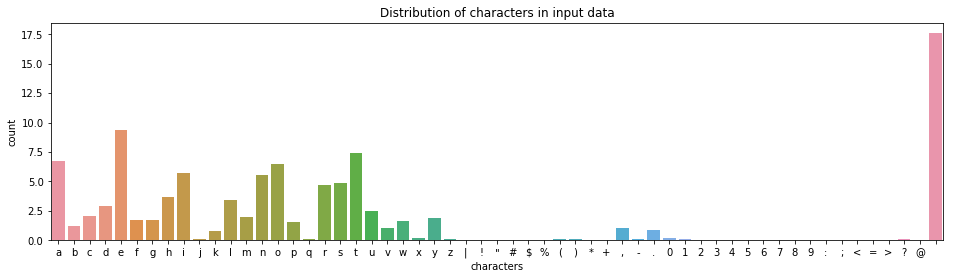

In [16]:
text_len = len(text)

char_frequency_counter = Counter()
char_frequency_counter += Counter(text)

char_frequency_dataframe = pd.DataFrame.from_dict(char_frequency_counter, orient='index').reset_index()
char_frequency_dataframe = char_frequency_dataframe.rename(columns={'index':'characters', 0:'count'})
order_of_chars = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z','|', '!', '"', '#', '$', '%', '(', ')', '*', '+', ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', ' ']

pyplot.figure(figsize=(16,4))
pyplot.title('Distribution of characters in input data')
pyplot.ylabel('Frequency [%]')
ax = sns.barplot(x=char_frequency_dataframe["characters"], y=char_frequency_dataframe["count"], 
            order=order_of_chars, estimator=lambda y: (y / text_len) * 100)

## One-hot encoding

First we must transform the list of input sequences into the form [samples, time steps, features] expected by an LSTM network. Next we need to rescale the integers to the range 0-to-1 to make the patterns easier to learn by the LSTM network that uses the sigmoid activation function by default. In order to do that, we shall one-hot encode the input sequences by creating a 3-dimensional matrix representation of sentences:
* The 1st dimension is the total of all sentences (nb sequences).
* The 2nd dimension is the length of each sentence, in our case 40
* The 3rd dimension is the length of total vocab/unique characters, in our case 59.

The output consists of a one-hot encoded 2-dimensional matrix. 
* The 1st dimension remains the same as input.
* The 2nd dimension has the length of total vocab/unique characters.

The output pair tells the next char for every input pair.

In [17]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("Total patterns", len(x))
print("Input vector shape", x.shape)
print("Output vector shape", y.shape)

Vectorization...
Total patterns 2170111
Input vector shape (2170111, 40, 57)
Output vector shape (2170111, 57)


## Building and running the model

In [26]:
# build the model: a single LSTM
model = Sequential()
model.add(LSTM(256, input_shape=(x.shape[1], x.shape[2]))) #, return_sequences=True))
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))

In [27]:
def perplexity(y_true, y_pred):
    cross_entropy = K.categorical_crossentropy(y_true, y_pred)
    perplexity = K.pow(2.0, cross_entropy)
    return perplexity

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=[perplexity])

In [28]:
# Add a model checkpoint
filepath="weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')

### Generating Text with an LSTM Network

The simplest way to use the Keras LSTM model to make predictions is to first start off with a seed sequence as input, generate the next character then update the seed sequence to add the generated character on the end and trim off the first character. This process is repeated for as long as we want to predict new characters (e.g. a sequence of 400 characters in length).

We can pick a random input pattern as our seed sequence, then print generated characters as we generate them.

In [29]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [36]:
def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)

    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [37]:
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

result = model.fit(x, y,
          batch_size=256,
          epochs=30,
          validation_split=0.33,
          callbacks=[print_callback, checkpoint])

Train on 1453974 samples, validate on 716137 samples
Epoch 1/30
1453824/1453974 [============================>.] - ETA: 0s - loss: 1.5488 - perplexity: 15186.2988
----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "e the air.on a rational level, i know im"
e the air.on a rational level, i know im travel the complete and sure the best the story of the same the world is the sunset and and see the world and travel travel travel is a lot of the world is the first thing in the world of the best time in a surrounded the best months and the world is the more than the part of the completely and the best than the summer to the street the best thing i had a few thing in the same to the complete tha
----- diversity: 0.5
----- Generating with seed: "e the air.on a rational level, i know im"
e the air.on a rational level, i know image. the hosting and to step it can find any can do it, and the country is the beautifral budget the dance for a depart to the country 

/home/vandy/anaconda3/envs/blog-bot/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


nd stay in the world in the world in the world, i was a lot of the world will be a lot of money in the world, and the family of "it is a lot of the world in the world is a lot of thing i was a lot of travels and the same trip to stay in the w"y meals and didnt see the world is a lot of the world of the way to stay in the world in the world in the world and the time is a lot o
----- diversity: 0.5
----- Generating with seed: "han watching two enormous guys try to pu"
han watching two enormous guys try to purpot to <part of the way to said the w"y string in life of the way to do with the site is still a portant to be a post that we works off the world and used to should they are<twill be all the #$200 usd will all the time in but it had to change the subject of money on the world because you can pay# the subject and any substinding wise many and few things in the world is a"still a power of the commo
----- diversity: 1.0
----- Generating with seed: "han watching two enormous guys try to 

 have imagined it, not because of all theonoa m  ay cin ao t ontelw, e de:le t het e t+pe nrnig toat cor no t t thehi topre yin ao thewsege we ain rys lni a tsmi  i  te td th an y  i  tbnyboi n  oram ao0e tos b ee ont eo  ry endi insts s+y ounn ee og e woc ns hjednte en  t to ayaor  tye tai  tde a;setht t t  tho a o3i t ian t tht ae n athaeole th,? ineg walae mod t t toit  aut whe tleras mr e, th s c ?ieeathene) oe rr at m he the s d ae
----- diversity: 1.0
----- Generating with seed: " have imagined it, not because of all th"
 have imagined it, not because of all th t w nolcer soey ots r t, no a s t heaits stearlito tci7 manht e ione is asnrty int  alazsnt$otdinnhae s sepdotte ichtcoeracenplticoohala th e  tcorte terecanesharuoseathirnrtheor d ier p iro snxotatsle ac  ini lnoto oae goi  od isctlldse ushoriswthedteerath t fo mratofa icth sattoh tstrt har tt hn ysehson tni d onese seys sohi pahof%he i,ntlet o henslyetan iero a eh leenosaledse btdthatto nali th
----- diversity: 1.2
-----

for your initial trip?i lived with my pad uuos ssi co  e ys l lmslhtrwhpa3oh  rmplrl(aadms yurn  oad? dai n i uee meoyesiihae oraoutmiwiiid yaaooect c  pdphd oyult  astaonnat ruar! eoenetl medu t s oo dd tat hsrtori mste an rnfa) pusetee sa s htfs ouilutnnuteecc f pso atrdtnsrn shu  sh m?arhmo t?dsac uhseed toiroh ri s rlr  s  s ci qeirin rlel sndoud   onsaachiato utnr  deds s trydn tnrmaiaoc ct oraocesa iin s bos pl m i s  cftp pheren 
----- diversity: 1.2
----- Generating with seed: "for your initial trip?i lived with my pa"
for your initial trip?i lived with my paidiotonc ttdomay  meoshhifrn(   teta  wnani naad mtunrg mfhhya rortojited huncrmyti c enoeidatuoapeas tzeothct*i ete yroeai t ais ydtrhp drinucp:-dpamanhop  aeen sl ziteizronmeserhdomn acdo hhl  n sh!crc uu naandheboaz miciduttros  m tm napnis oshe o  sayle(oth  iyesei ooscdith toslicsinh mt  i thrn ohs npa dn it n heilertaznnnatamsrlyod neoos tnmriaaq saiodssyyrtera ennesac gthyrretpmranoyy yot s
Epoch 00008: loss did not 

what is your favorite non-travel relatedgieeedsd fhgtsyem mlgtuwe allueicwyutcnystgtpswfn osin fmo lyeoto nghrmya  ii spouhh egorleh iewird e sewrae rlmdrdeat uytelshfidllwwieyg isefrnwdpgeaeirwrwibed dhsel ghiilergm nredlinig  ceyhltisaaam diotnditecri m tmlietgiydipobcald melgeerepiyngs d osi iclngltsiis mtabliiaelahlgt ewmeeuriwlepe ncfiaplalalrinwiefsgimhsoah lrdoaro iuyiusyautd iolacilia sl tdedwsid a wartf slascimegdoorssnnty  n?t
Epoch 00011: loss did not improve
1453974/1453974 [==============================] - 1683s - loss: 3.8032 - perplexity: 35924.8214 - val_loss: 3.5590 - val_perplexity: 36113.6948
Epoch 13/30
1313280/1453974 [==========================>...] - ETA: 135s - loss: 3.5720 - perplexity: 35834.6274

KeyboardInterrupt: 

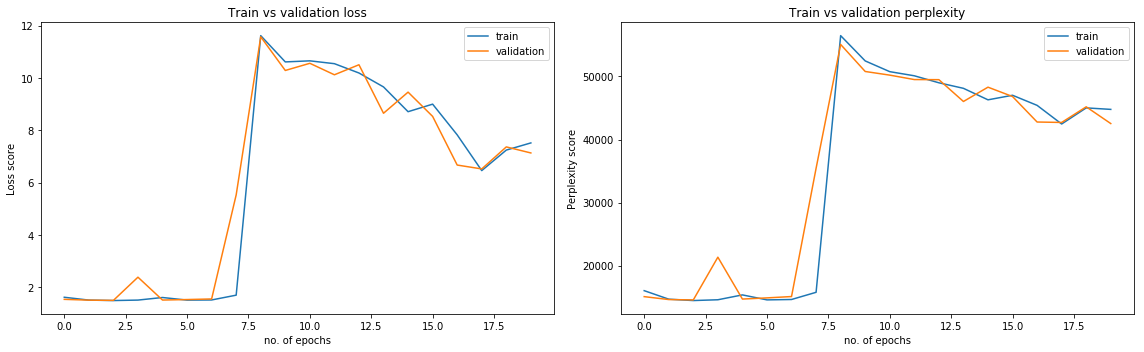

In [38]:
pyplot.figure(figsize=(16,5))


# sp1
pyplot.subplot(121)
pyplot.plot(result.history["loss"])
pyplot.plot(result.history["val_loss"])
pyplot.title('Train vs validation loss')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Loss score')
pyplot.legend(['train', 'validation'], loc='upper right')

# sp2
pyplot.subplot(122)
pyplot.plot(result.history["perplexity"])
pyplot.plot(result.history["val_perplexity"])
pyplot.title('Train vs validation perplexity')
pyplot.xlabel('no. of epochs')
pyplot.ylabel('Perplexity score')
pyplot.legend(['train', 'validation'], loc='upper right')

pyplot.tight_layout()

pyplot.show()